In [1]:
library("Matrix")

In [2]:
library("SCENIC")

Warning message:
“multiple methods tables found for ‘which’”
Warning message:
“multiple methods tables found for ‘which’”


In [3]:
library("Seurat")

Attaching SeuratObject



In [4]:
library("RcisTarget")

In [5]:
library("doParallel")

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [6]:
library("SCopeLoomR")


Attaching package: ‘SCopeLoomR’


The following object is masked from ‘package:base’:

    flush




In [7]:
library(BiocGenerics)


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min




In [8]:
library(cowplot)

In [9]:
dir.create("SCENIC_0711")
setwd("SCENIC_0711") 

Warning message in dir.create("SCENIC_0711"):
“'SCENIC_0711' already exists”


In [10]:
load(file="../0711-ob.integratve-7samples.Rda")

In [11]:
allPC3<-ob.integrated

In [12]:
exprMat<-GetAssayData(allPC3,slot="data")
exprMat<-as.matrix(exprMat)
exprMat_log <- log2(exprMat+1)

Warning message in eval(expr, envir, enclos):
“NaNs produced”


In [13]:
exprMat_log[is.na(exprMat_log)]<-0

In [14]:
dir.create("int")

Warning message in dir.create("int"):
“'int' already exists”


In [15]:
cellInfo <- data.frame(seuratCluster=Idents(allPC3))

In [16]:
cellInfo$nGene <- colSums(exprMat>0)
head(cellInfo)

,seuratCluster,nGene
,<fct>,<dbl>
AAACCTGAGTTTAGGA-1_1,1,1282
AAACCTGCAAGCGTAG-1_1,0,1202
AAACCTGCACCTGGTG-1_1,0,1264
AAACCTGGTCTGCCAG-1_1,0,1265
AAACGGGAGATGCCTT-1_1,0,1275
AAACGGGAGCTGAACG-1_1,3,914


In [17]:
cellInfo <- data.frame(cellInfo)
cbind(table(cellInfo$seuratCluster))
saveRDS(cellInfo, file="int/cellInfo.Rds")

0,7185
1,2570
2,1760
3,975
4,845
5,486
6,260


In [18]:
scenicOptions <- initializeScenic(org="hgnc", dbDir="/together_sdb/zhoujiaqi/index", nCores=1)
#scenicOptions@inputDatasetInfo$cellInfo <- "int/cellInfo.Rds"
saveRDS(scenicOptions, file="int/scenicOptions.Rds") 

Motif databases selected: 
  hg19-500bp-upstream-7species.mc9nr.feather 
  hg19-tss-centered-10kb-7species.mc9nr.feather

Warning message in RcisTarget::importRankings(dbFilePath, randomCol):
“The following columns are missing from the database: ”
Warning message in RcisTarget::importRankings(dbFilePath, randomCol):
“The following columns are missing from the database: ”


In [19]:
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

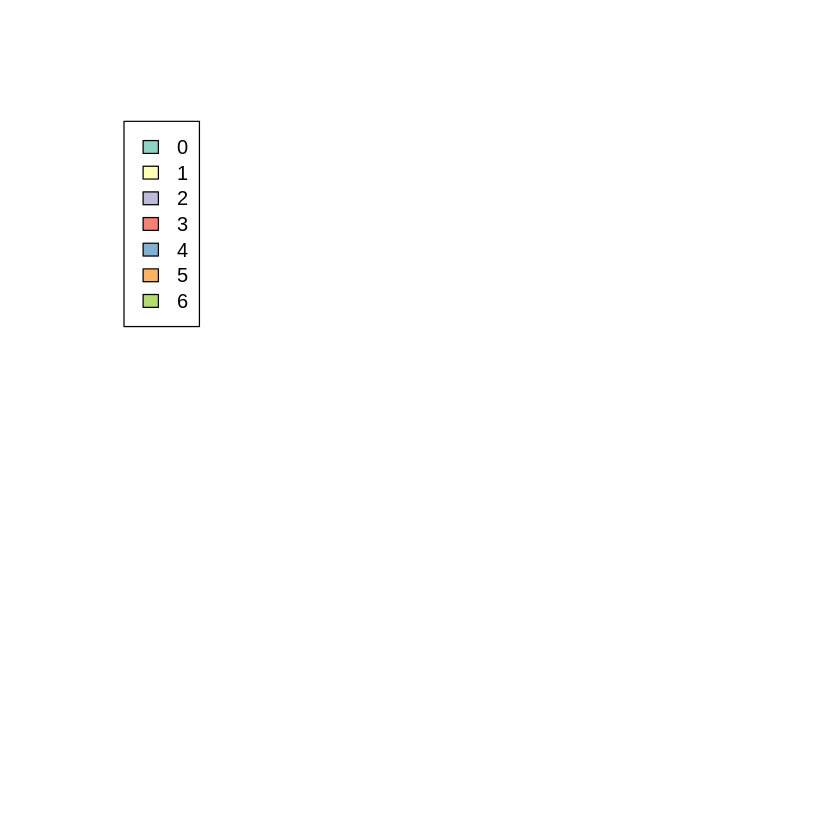

In [20]:
library(RColorBrewer)
colVars <- list(seuratCluster=c("0"=brewer.pal(8,'Set3')[1], 
                           "1"=brewer.pal(8, 'Set3')[2], 
                           "2"=brewer.pal(8,'Set3')[3], 
                           "3"=brewer.pal(8,'Set3')[4], 
                           "4"=brewer.pal(8,'Set3')[5],  
                           "5"=brewer.pal(8,'Set3')[6],
                          "6"=brewer.pal(8,'Set3')[7]))
colVars$seuratCluster <- colVars$seuratCluster[intersect(names(colVars$seuratCluster), cellInfo$seuratCluster)]
plot.new(); legend(0,1, fill=colVars$seuratCluster, legend=names(colVars$seuratCluster))

In [21]:
saveRDS(colVars, file="int/colVars.Rds")

In [22]:
# (Adjust minimum values according to your dataset)
genesKept <- geneFiltering(exprMat, scenicOptions=scenicOptions,
                           minCountsPerGene=3*.01*ncol(exprMat),
                           minSamples=ncol(exprMat)*.01)

Maximum value in the expression matrix: 11.8068979674192

Ratio of detected vs non-detected: 1.7

Number of counts (in the dataset units) per gene:



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -136.5   141.1   407.7  1506.9  1114.8 96039.5 


Number of cells in which each gene is detected:



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2274    5092    6083    6406    7251   14081 



Number of genes left after applying the following filters (sequential):

	981	genes with counts per gene > 422.43

	981	genes detected in more than 140.81 cells

	917	genes available in RcisTarget database

Gene list saved in int/1.1_genesKept.Rds



In [23]:
exprMat_filtered <- exprMat[genesKept, ]
dim(exprMat_filtered)

[1]   917 14081

In [24]:
runCorrelation(exprMat_filtered, scenicOptions)

In [25]:
saveRDS(exprMat_filtered,file="exprMat_filtered.Rds")

In [ ]:
# Run GENIE3
runGenie3(exprMat_filtered, scenicOptions)

Using 446 TFs as potential regulators...

Warning message in runGenie3(exprMat_filtered, scenicOptions):
“Only 24% of the 1839 TFs in the database were found in the dataset. Do they use the same gene IDs?
”
Running GENIE3 part 1



In [51]:
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

In [52]:
runSCENIC_1_coexNetwork2modules(scenicOptions)

16:59	Creating TF modules



       75%        90% 
0.01189180 0.01400829 


Number of links between TFs and targets: 83356



            [,1]
nTFs          91
nTargets     917
nGeneSets    546
nLinks    230805


In [54]:
runSCENIC_2_createRegulons(scenicOptions,minGenes = 20)

16:59	Step 2. Identifying regulons

tfModulesSummary:




 top5perTarget top10perTarget          top50 top50perTarget           w001 
            22             44             89             91             91 
          w005 
            91 


16:59	RcisTarget: Calculating AUC

Scoring database:  [Source file: hg19-500bp-upstream-7species.mc9nr.feather]

Scoring database:  [Source file: hg19-tss-centered-10kb-7species.mc9nr.feather]

17:16	RcisTarget: Adding motif annotation

Using BiocParallel...

Using BiocParallel...

Number of motifs in the initial enrichment: 151844

Number of motifs annotated to the matching TF: 5931

17:17	RcisTarget: Prunning targets

17:38	Number of motifs that support the regulons: 5931



[1] "Saving a widget with selfcontained = TRUE requires pandoc. For details see:\nhttps://github.com/rstudio/rmarkdown/blob/master/PANDOC.md"


In [57]:
runSCENIC_3_scoreCells(scenicOptions, exprMat_log)

17:39	Step 3. Analyzing the network activity in each individual cell

	Number of regulons to evaluate on cells: 70
Biggest (non-extended) regulons: 
	 IRF7 (269g)
	 IRF4 (253g)
	 IRF1 (252g)
	 STAT1 (231g)
	 FOS (184g)
	 XBP1 (176g)
	 GABPB1 (164g)
	 CEBPB (153g)
	 ATF3 (137g)
	 ARID5B (102g)

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



 min   1%   5%  10%  50% 100% 
  15   55  177  214 1146 1602 


17:43	Finished running AUCell.

17:43	Plotting heatmap...

17:43	Plotting t-SNEs...



In [60]:
runSCENIC_4_aucell_binarize(scenicOptions)

Binary regulon activity: 38 TF regulons x 14081 cells.
(52 regulons including 'extended' versions)
29 regulons are active in more than 1% (140.81) cells.



In [26]:
tsneAUC(scenicOptions, aucType="AUC") 

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


[1] "int/tSNE_AUC_50pcs_50perpl.Rds"

In [29]:
export2scope(scenicOptions, exprMat)

[1] "Adding global attributes..."


Warning message in if (class(dgem) == "dgTMatrix") {:
“the condition has length > 1 and only the first element will be used”


[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Default metric nUMI was not added because the input matrix does not seem to be the raw counts.”


[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns edges..."
[1] "Adding row edges..."
[1] "Adding layers..."
[1] "Adding embedding SCENIC: tSNE_AUC_05pcs_05perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_05pcs_100perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_05pcs_15perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_05pcs_50perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_100pcs_05perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_100pcs_100perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_100pcs_15perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_100pcs_50perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_15pcs_05perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_15pcs_100perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_15pcs_15perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_15pcs_50perpl.Rds..."
[1] "Adding embedding SCENIC: tSNE_AUC_50pcs_05perpl.Rds..."
[1] "Adding embedd

Loom file saved as:	output/scenic.loom



In [26]:
nPcs <- c(5,15,50,100)

In [27]:
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

In [28]:
# Run t-SNE with different settings:
fileNames <- tsneAUC(scenicOptions, aucType="AUC", nPcs=nPcs, perpl=nPcs)
fileNames <- tsneAUC(scenicOptions, aucType="AUC", nPcs=nPcs, perpl=nPcs, onlyHighConf=TRUE, filePrefix="int/tSNE_oHC")
# Plot as pdf (individual files in int/):
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_", list.files("int"), value=T), value=T))

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


In [29]:
options(repr.plot.height=15,repr.plot.width=15)

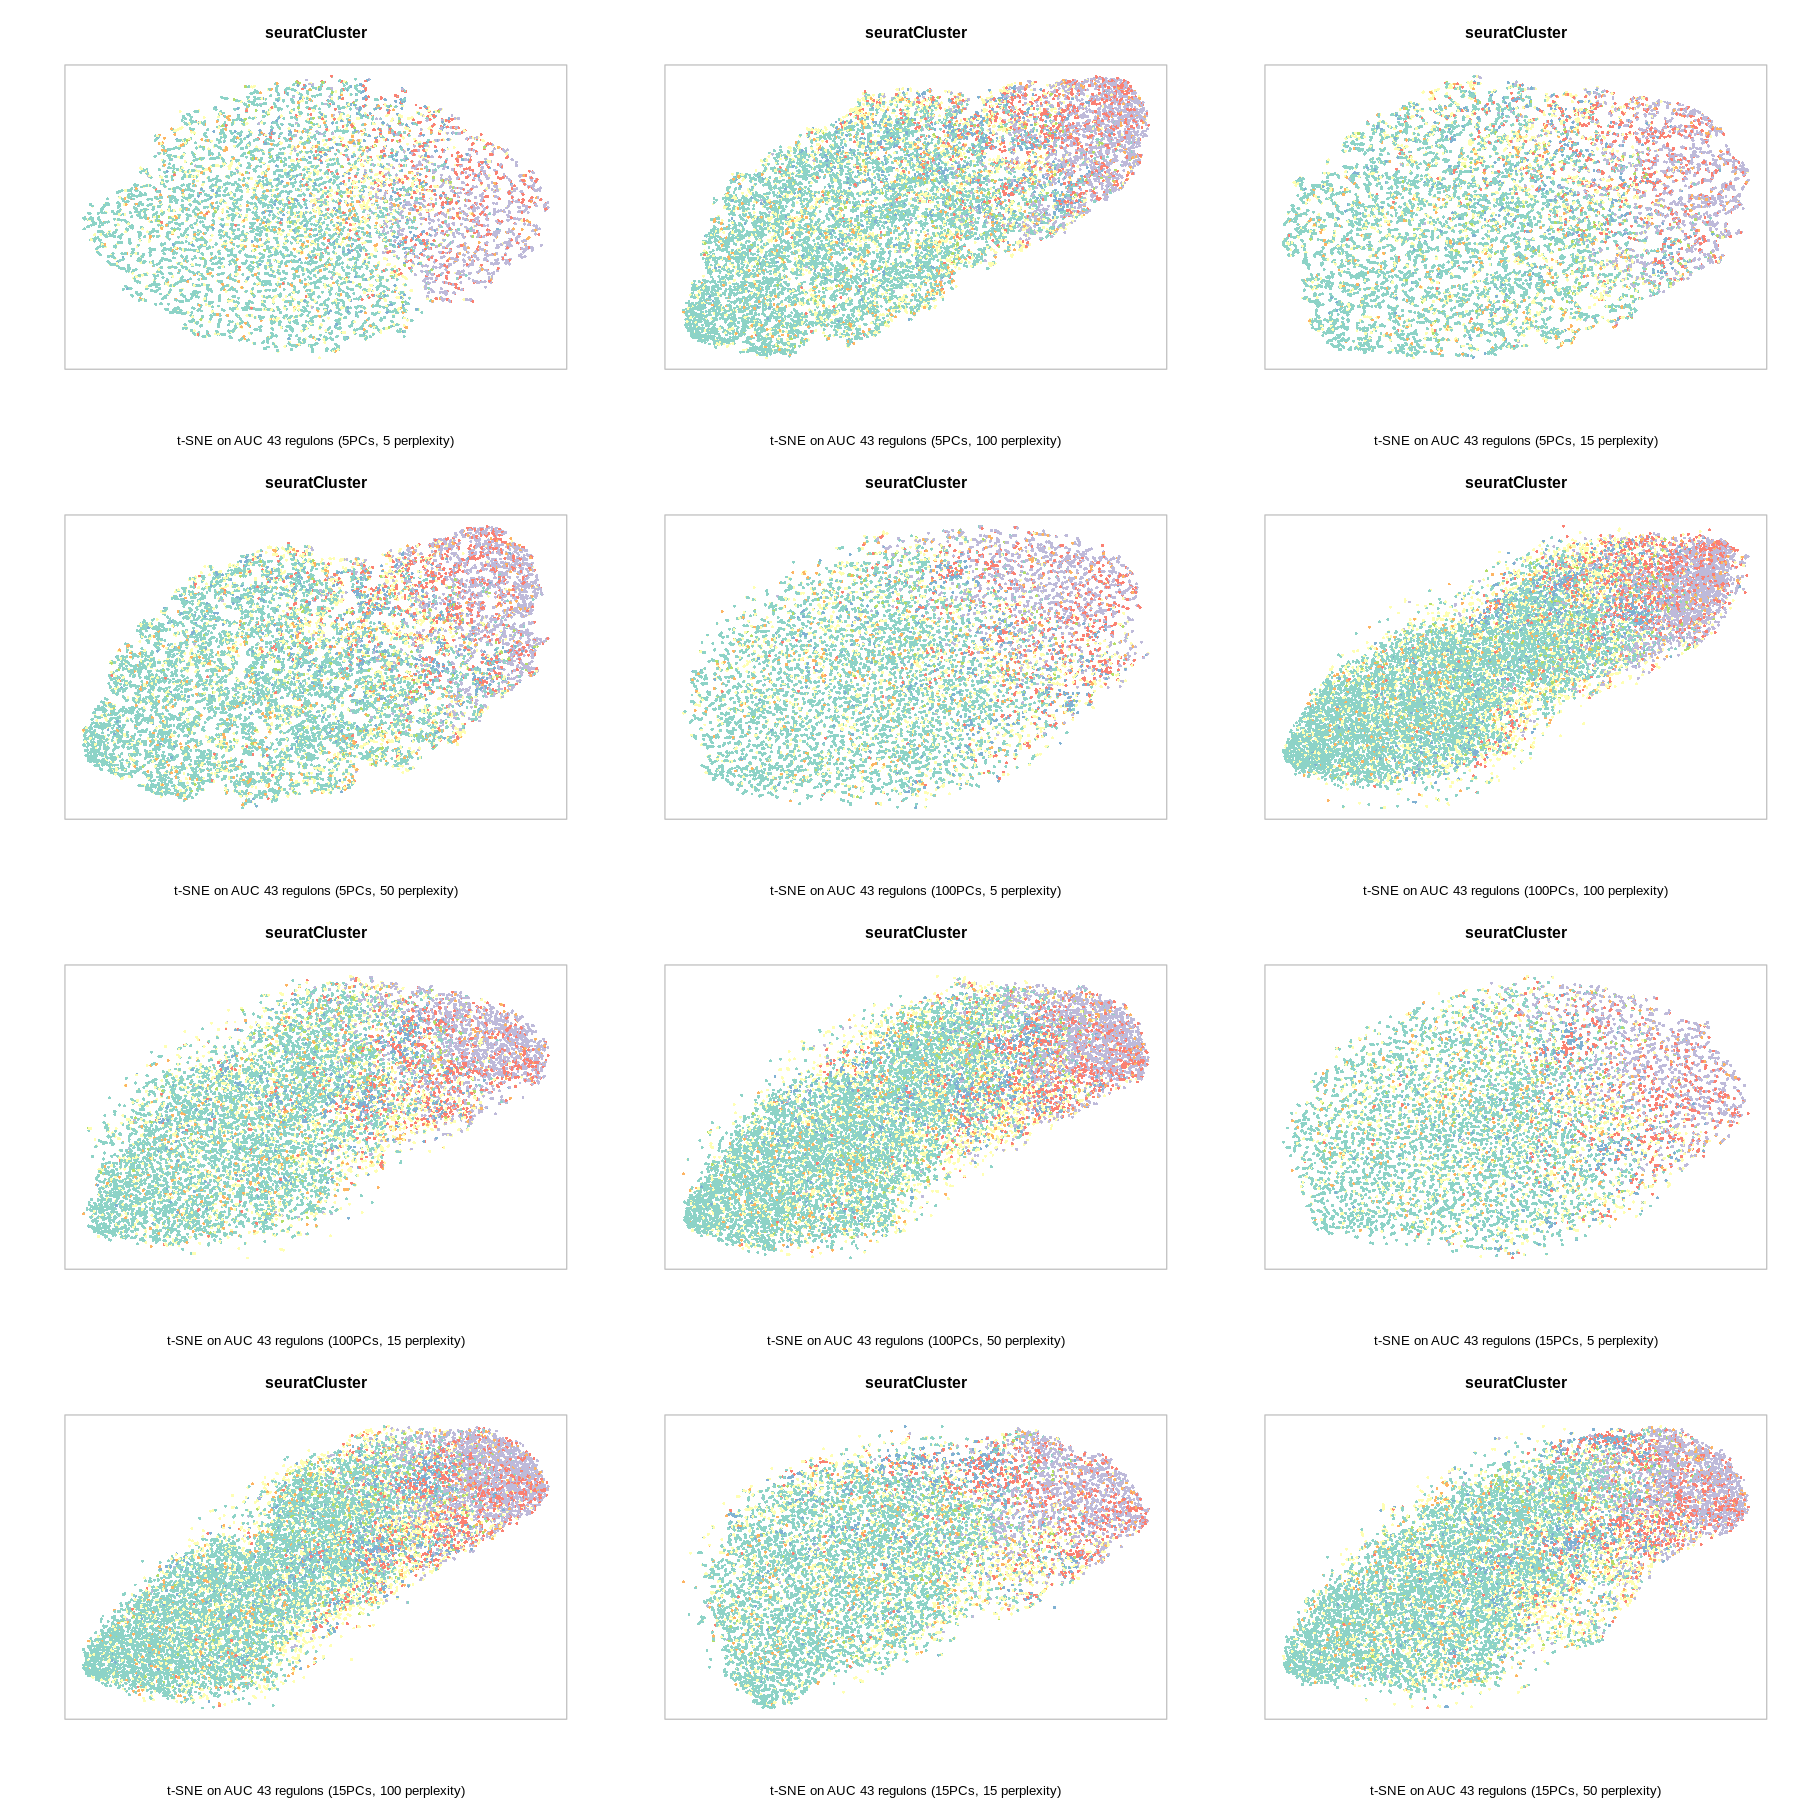

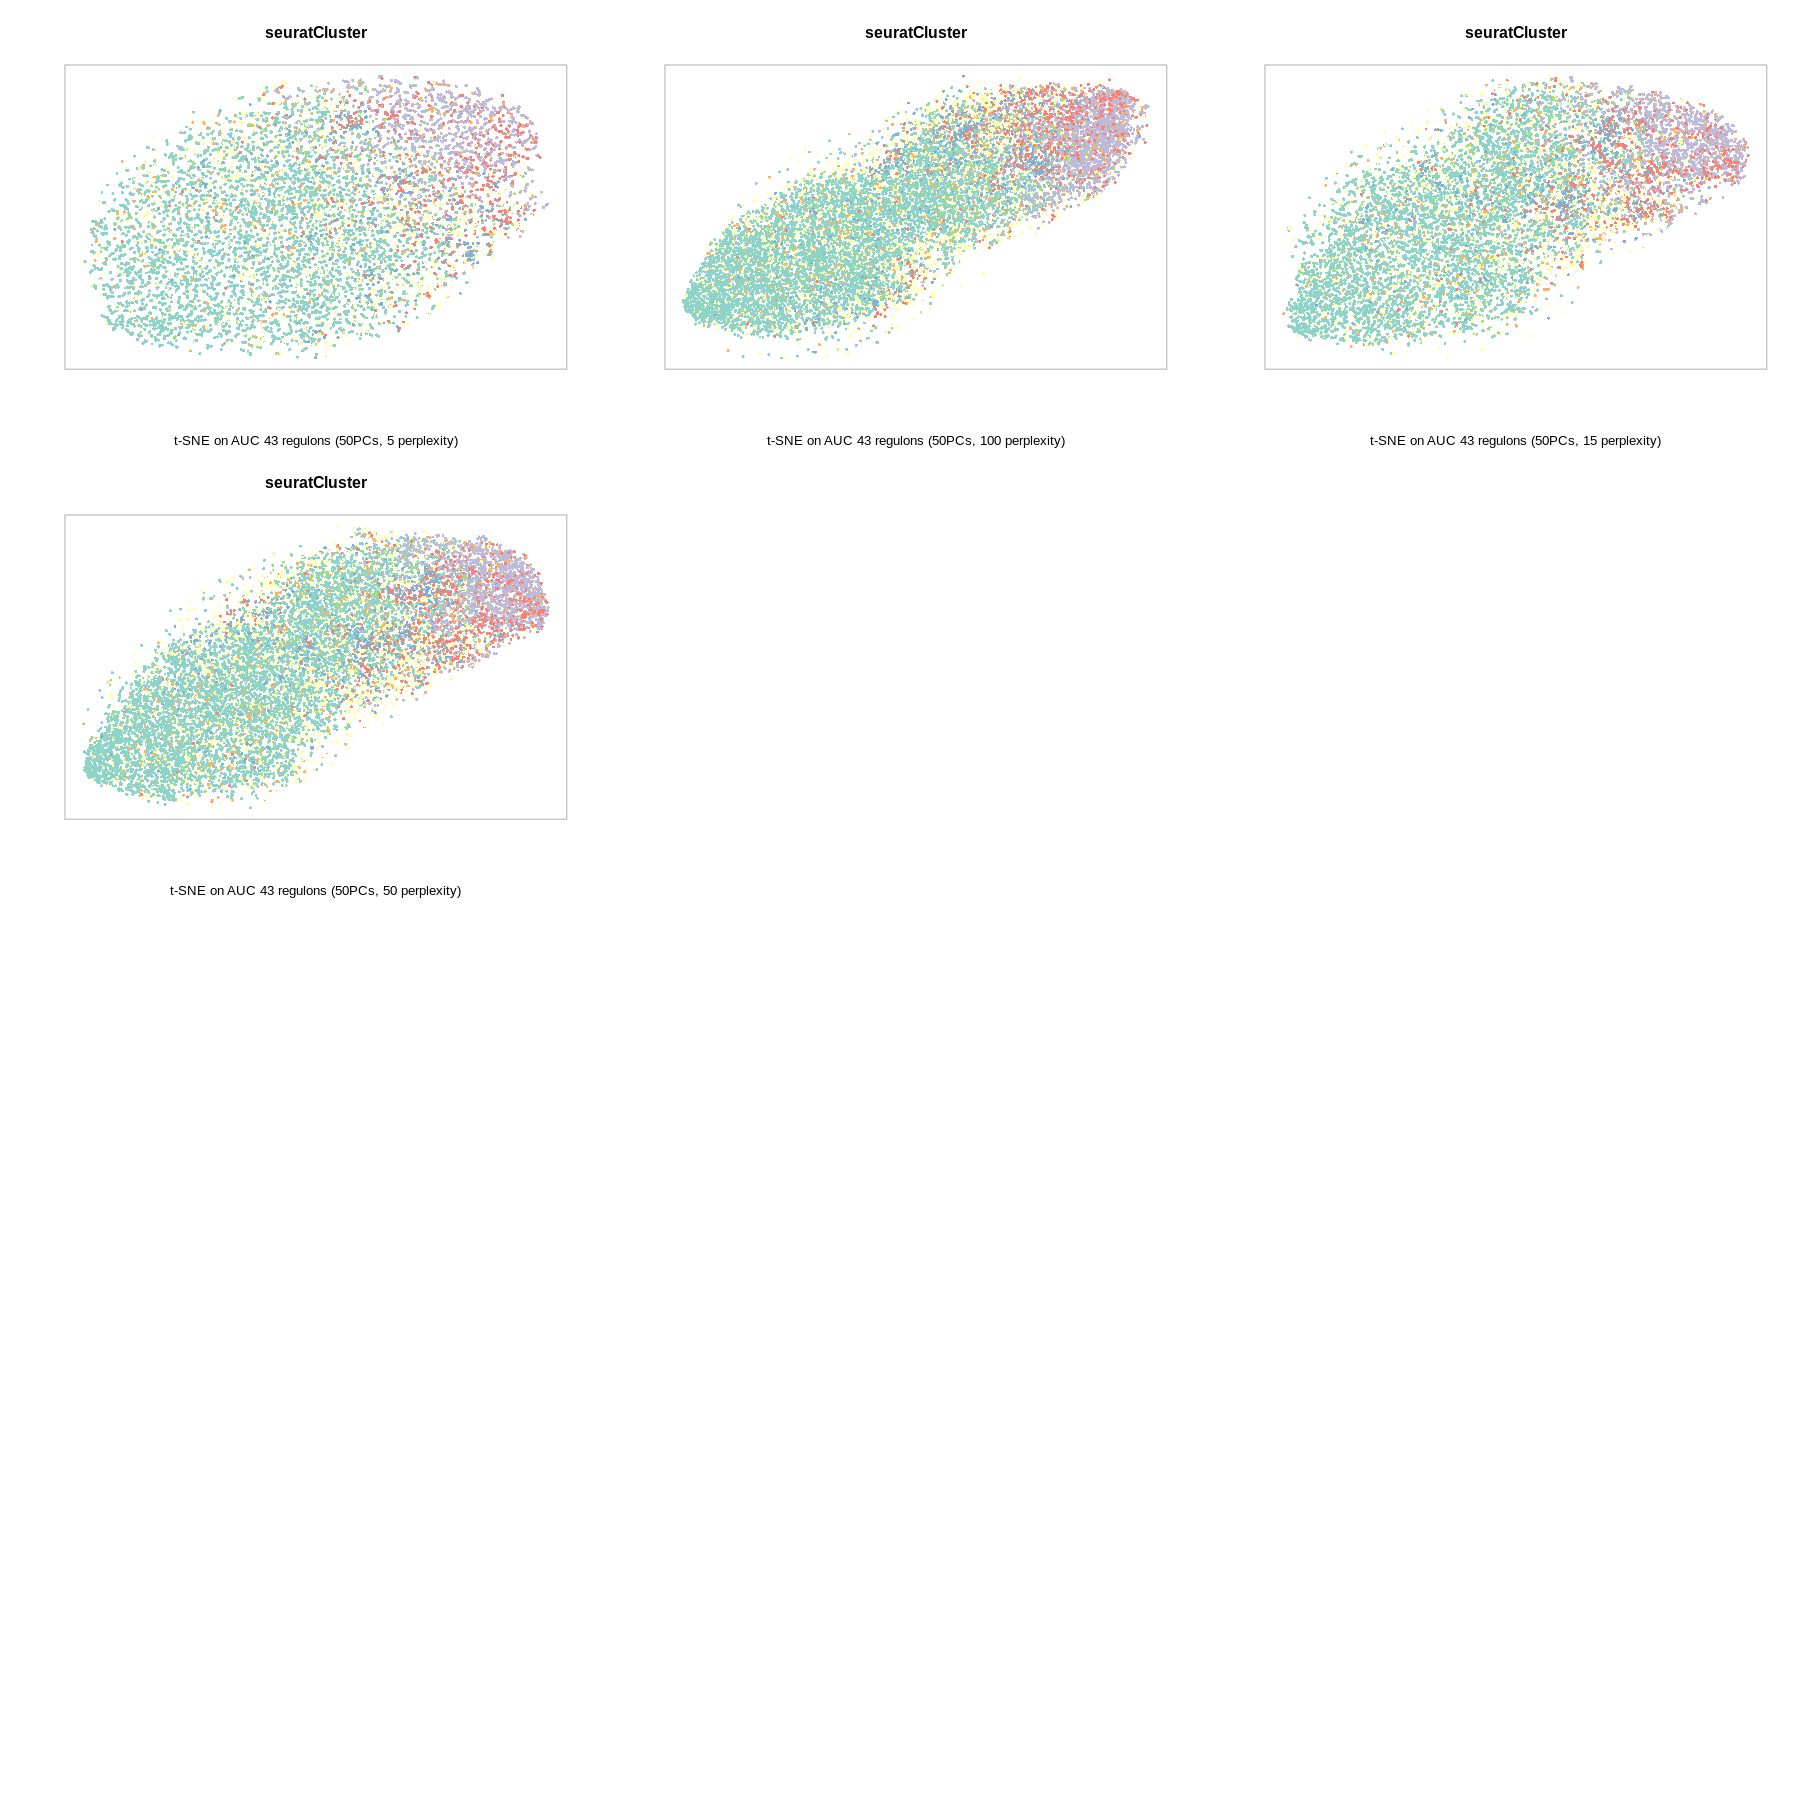

In [30]:
par(mfrow=c(length(nPcs), 3))
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_AUC", list.files("int"), value=T, perl = T), value=T))
plotTsne_compareSettings(fileNames, scenicOptions, showLegend=FALSE, varName="seuratCluster", cex=.5)

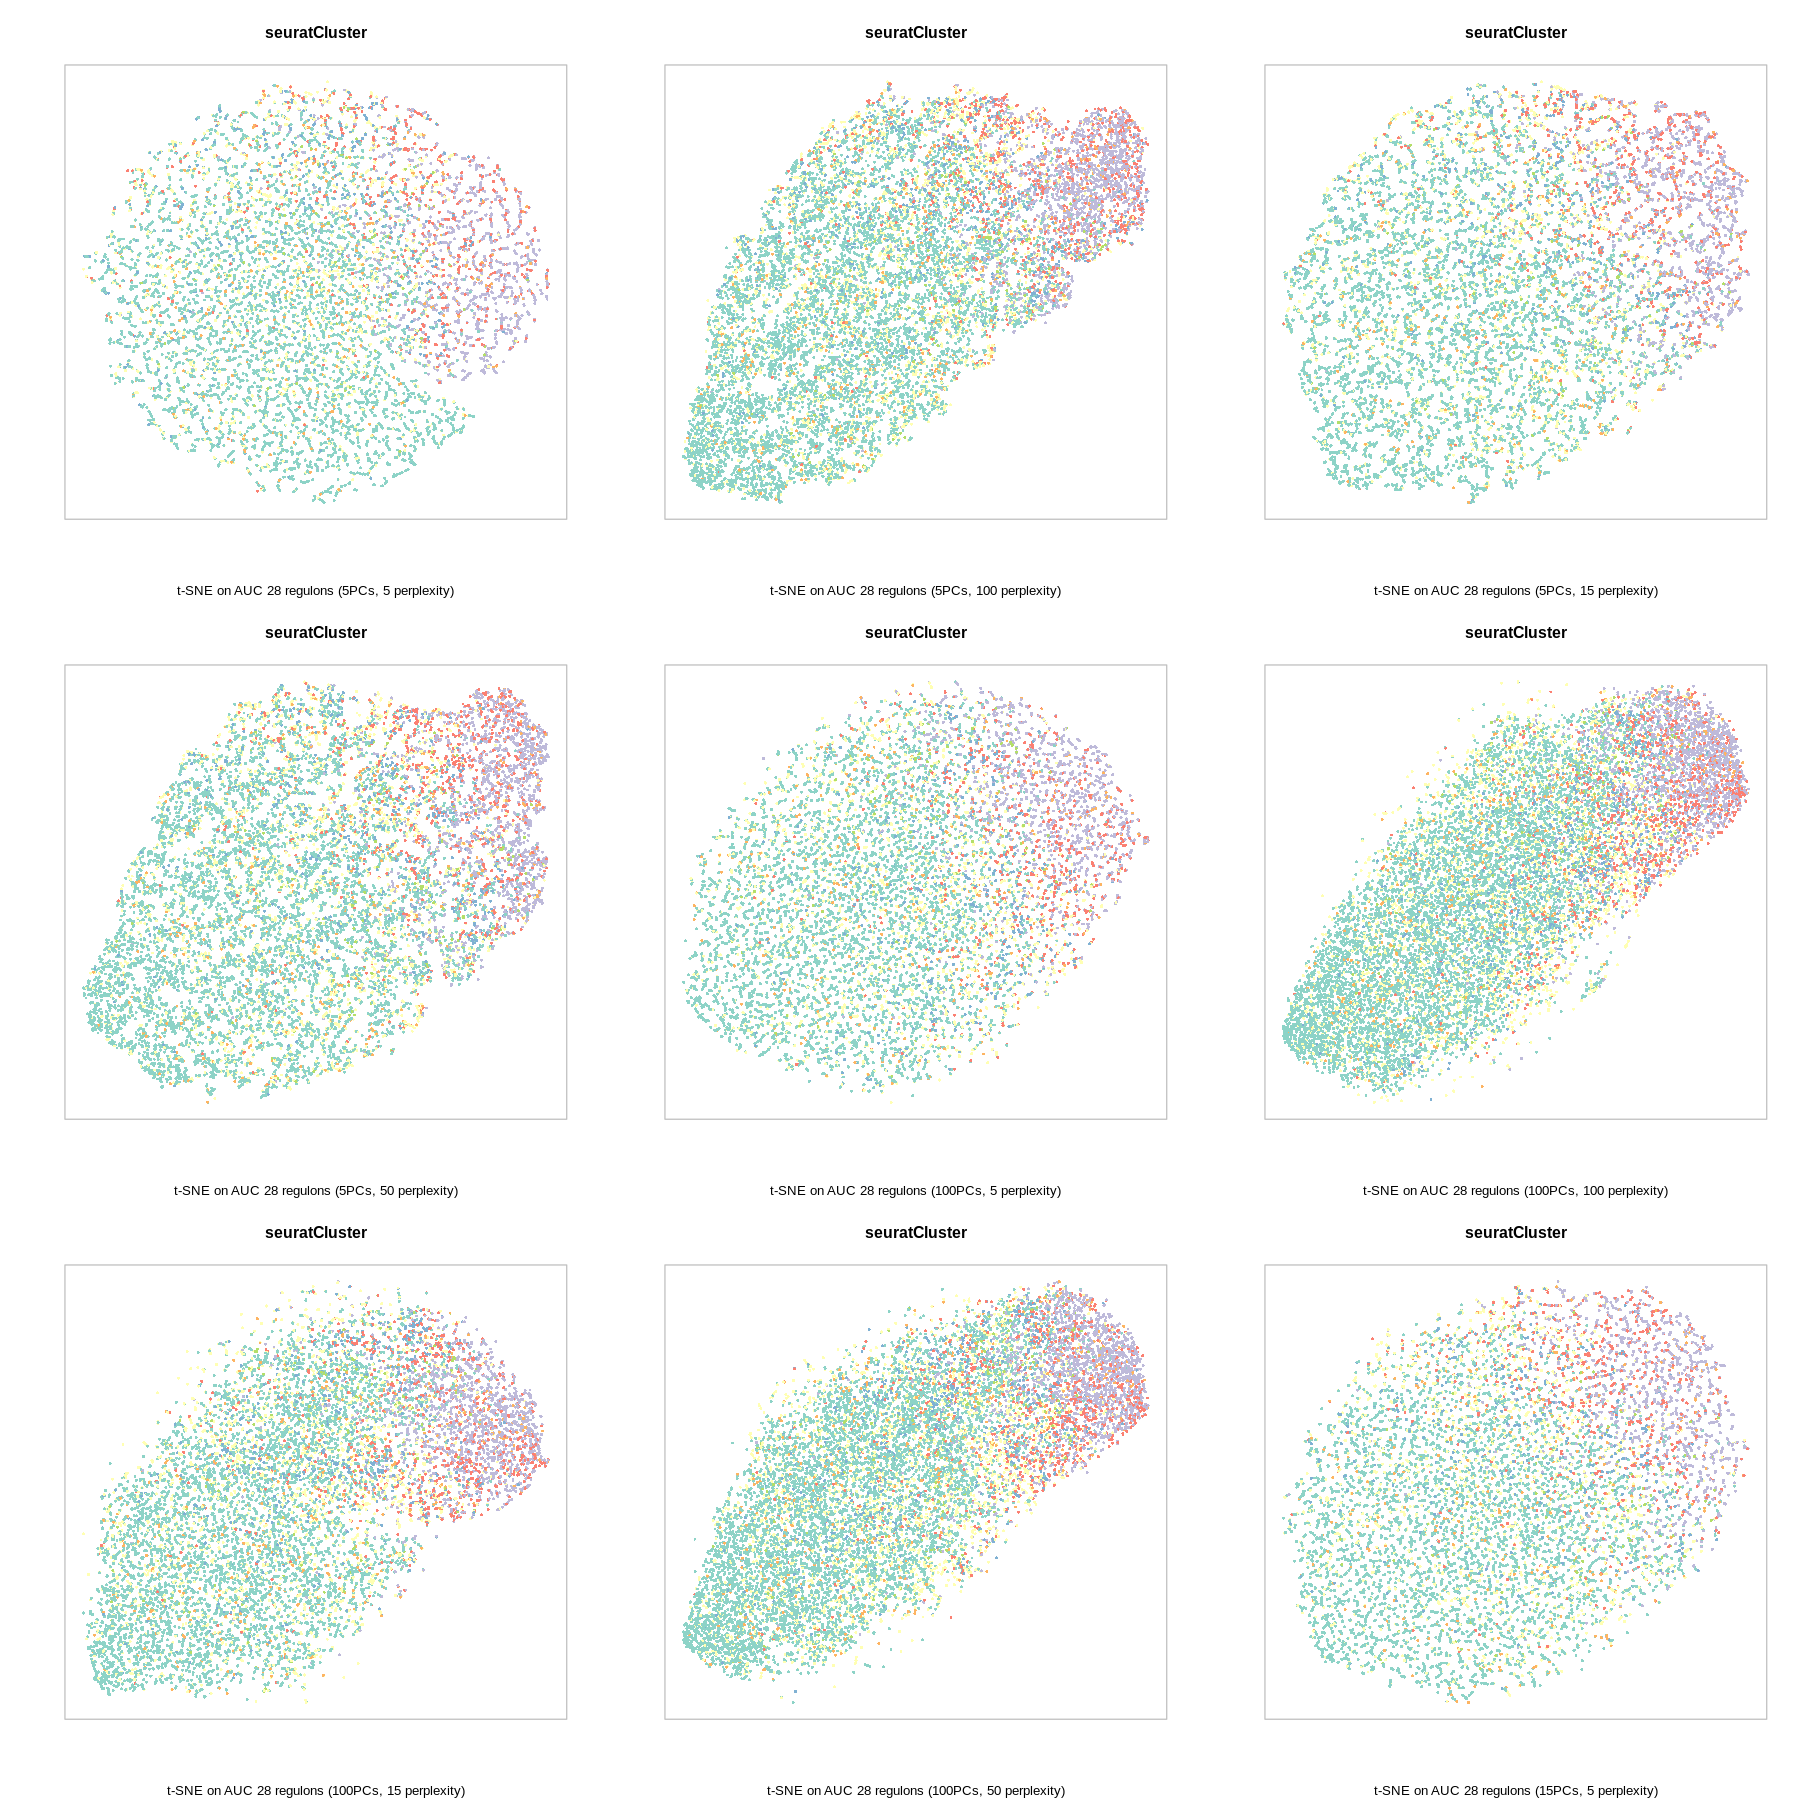

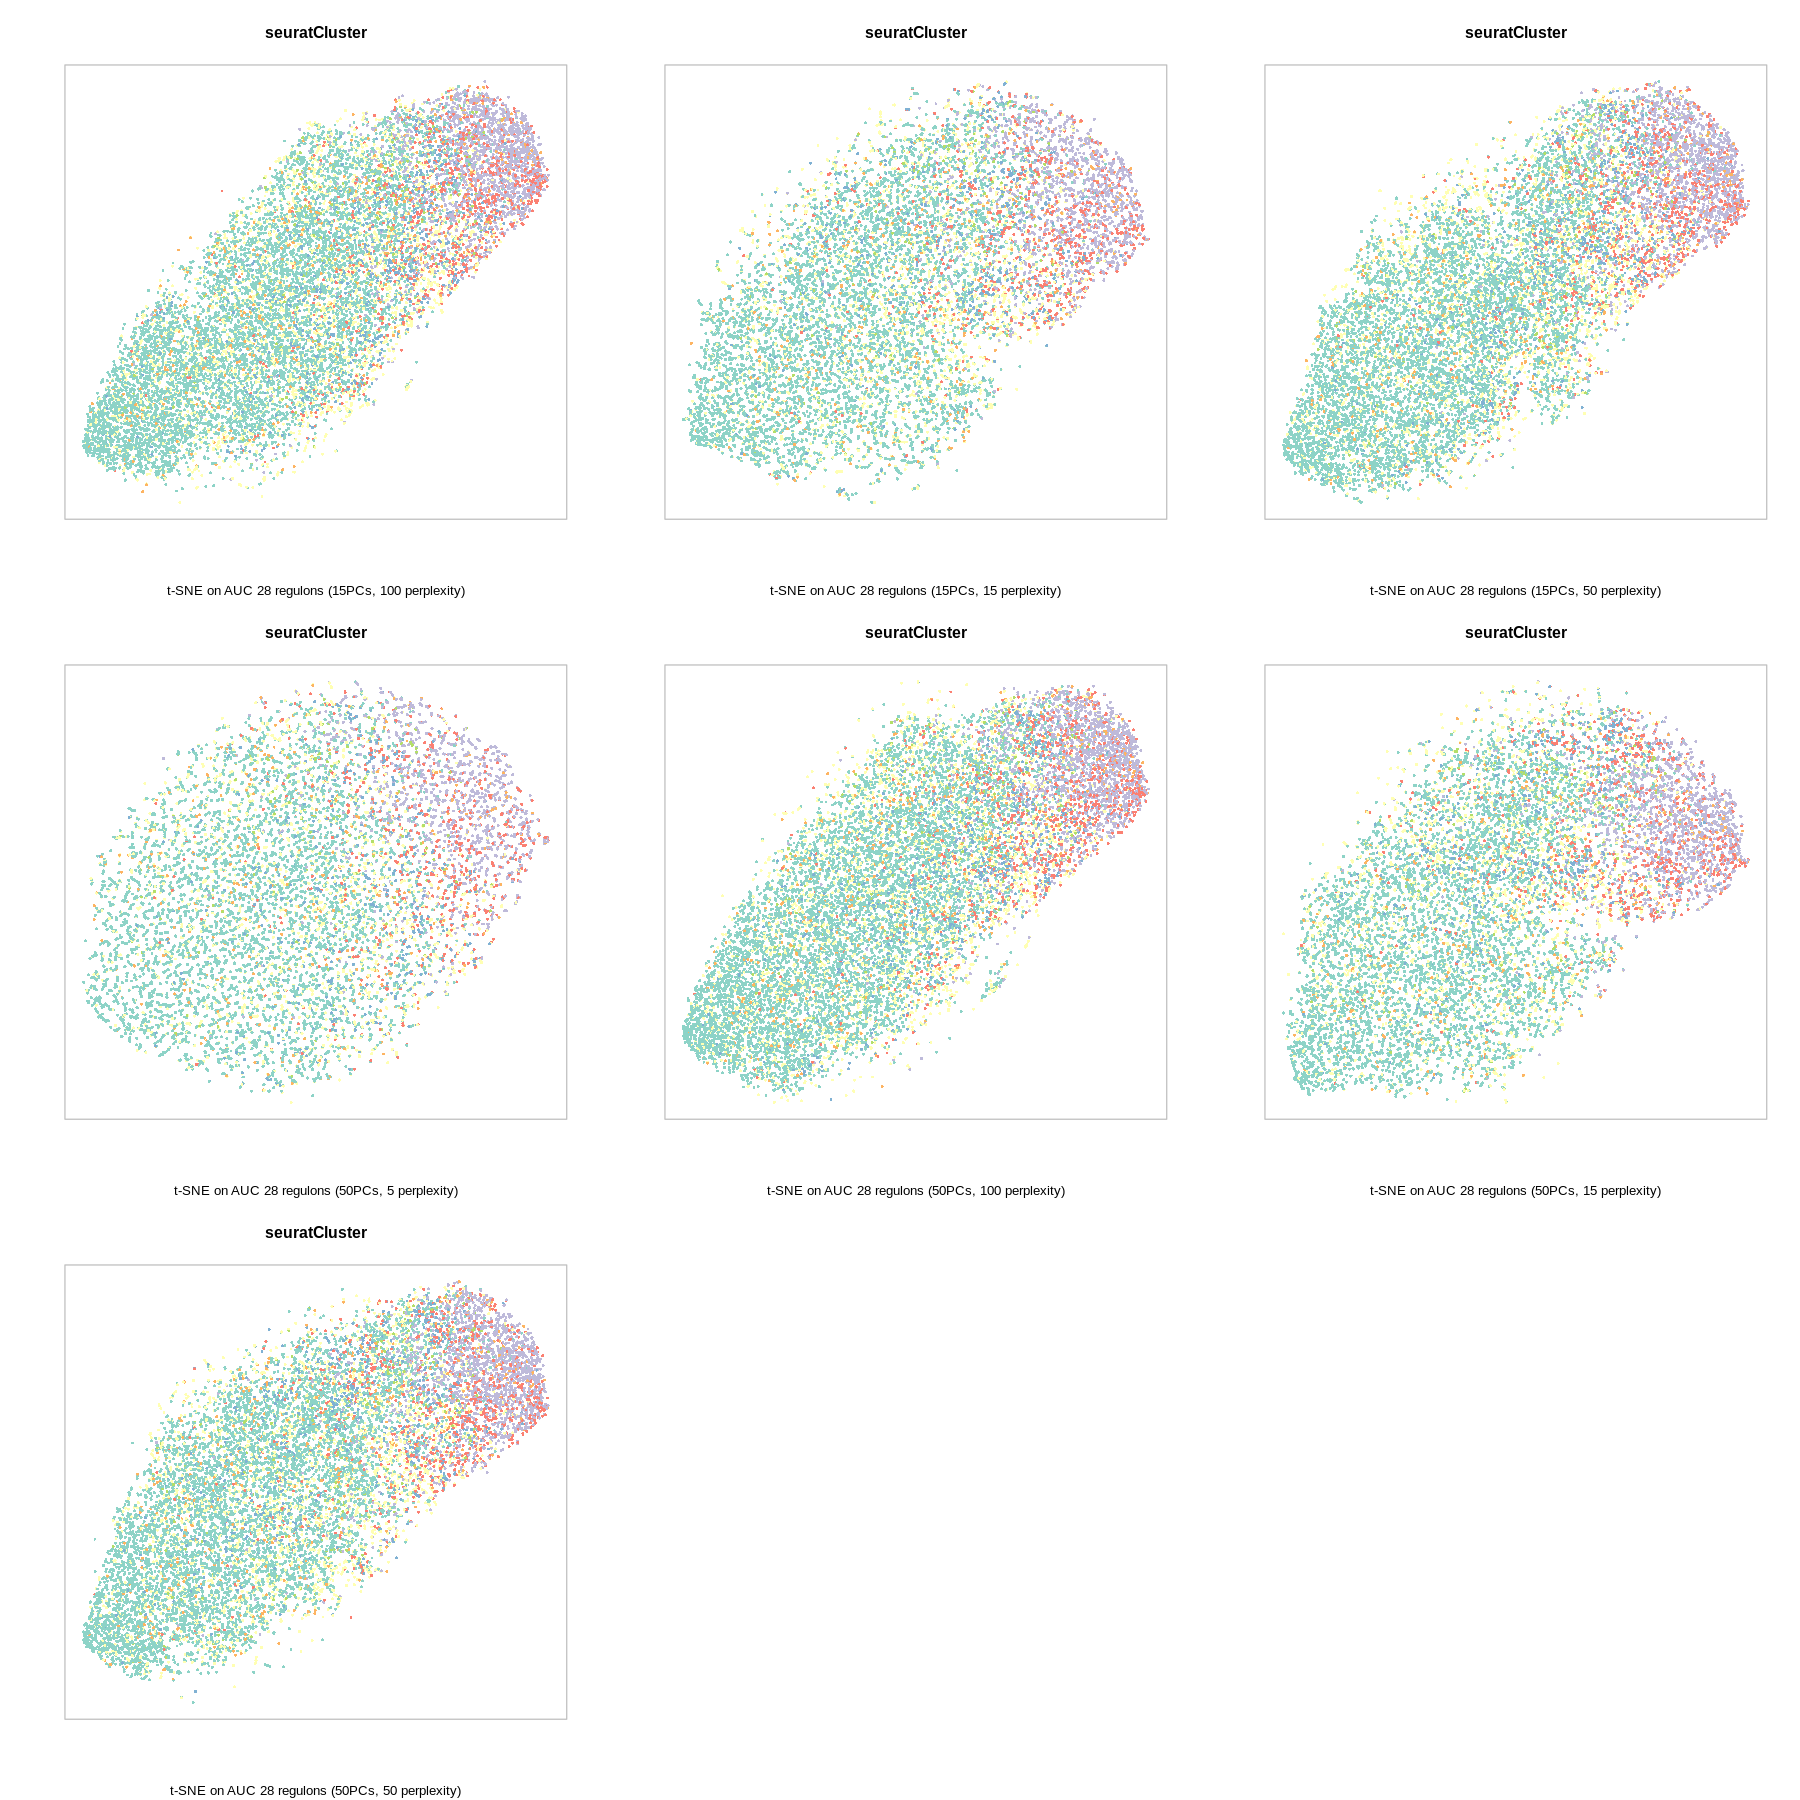

In [31]:
# Using only "high-confidence" regulons (normally similar)
par(mfrow=c(3,3))
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_oHC_AUC", list.files("int"), value=T, perl = T), value=T))
plotTsne_compareSettings(fileNames, scenicOptions, showLegend=FALSE, varName="seuratCluster", cex=.5)

In [32]:
tSNE_scenic <- readRDS(tsneFileName(scenicOptions))
aucell_regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")

In [33]:
regulons <- loadInt(scenicOptions, "aucell_regulons")
head(cbind(onlyNonDuplicatedExtended(names(regulons))))

IRF1,IRF1 (252g)
IRF7,IRF7 (269g)
IRF4,IRF4 (253g)
STAT1,STAT1 (231g)
CEBPB,CEBPB (153g)
ATF3,ATF3 (137g)


In [34]:
regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]
regulonActivity_byCellType <- sapply(split(rownames(cellInfo), cellInfo$seuratCluster),
                                     function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
regulonActivity_byCellType_Scaled <- t(scale(t(regulonActivity_byCellType), center = T, scale=T))
regulonActivity_byCellType_Scaled

,0,1,2,3,4,5,6
MYC (52g),0.9028433,0.473639162,-1.48836656,0.27473532,1.1675102956,-1.12442701,-0.20593450
CEBPG (53g),0.5532447,0.803524710,-0.81906100,1.58135658,-0.2057286910,-0.91213402,-1.00120228
IRF9 (48g),-0.9495933,0.086417025,0.45413539,1.26264325,1.0746281739,-0.59233877,-1.33589174
NFIC_extended (43g),-1.1426416,0.295855443,1.95269401,0.29716736,-0.2906457567,-0.59007361,-0.52235586
DDIT3 (71g),-0.9242615,0.522720479,1.90551559,-0.12439603,-1.0167110489,-0.43293147,0.07006397
SMARCC2_extended (14g),-1.2219416,-0.487335982,0.19351997,0.09139717,-0.4191161717,-0.16193550,2.00541207
XRCC4_extended (91g),-0.5272980,-0.620689322,-0.15710053,-0.55650986,-0.6922615281,2.07128256,0.48257672
RREB1_extended (14g),-1.0573261,-0.178124018,0.73478986,0.22156301,-0.5701763388,1.76172191,-0.91244833
POU2F2 (22g),-0.7816023,1.452430245,-0.03541276,0.70755761,0.5489090352,-0.35996186,-1.53191992
CTNNB1_extended (11g),-1.1124787,1.651614860,1.02157222,0.11329461,-0.6845896263,-0.39475262,-0.59466073


In [35]:
options(repr.plot.height=15,repr.plot.width=15)

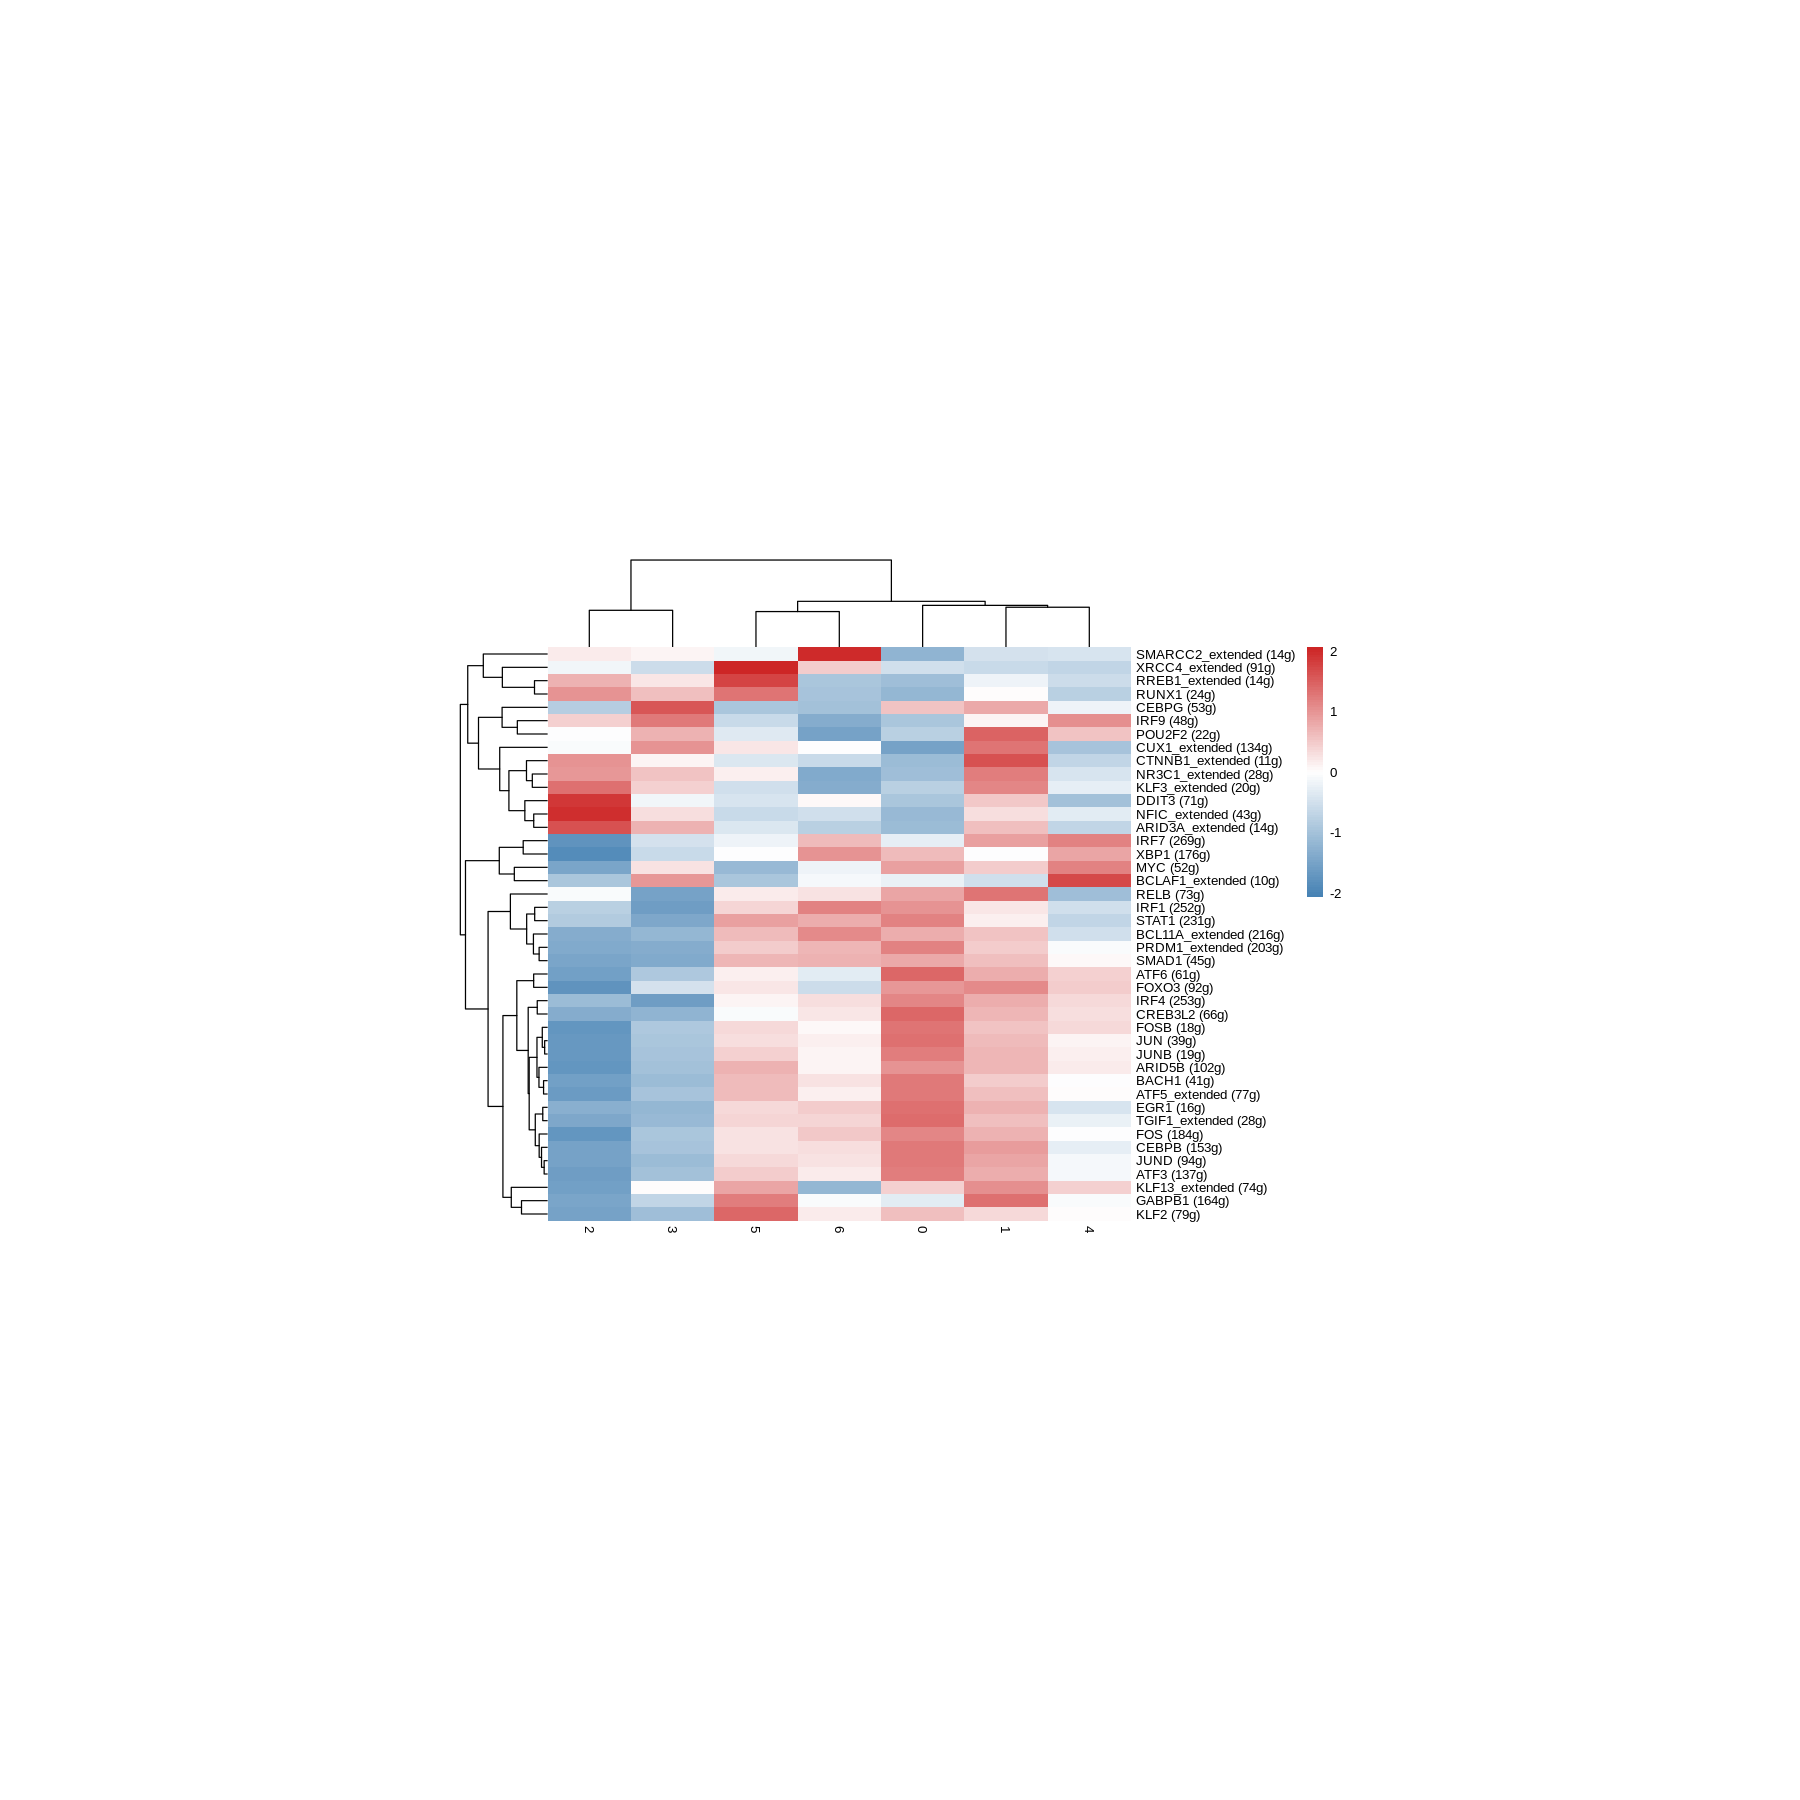

In [36]:
library(pheatmap)
pheatmap(regulonActivity_byCellType_Scaled,scale="row",border=FALSE,color=colorRampPalette(c("steelblue","white","firebrick3"))(100),cellheight=8,cellwidth=50,fontsize=8)

In [37]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Scaled)
colnames(topRegulators) <- c("Regulon", "seuratCluster", "RelativeActivity")
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>0),]
viewTable(topRegulators)

HTML widgets cannot be represented in plain text (need html)

In [38]:
minPerc <- 0.3
binaryRegulonActivity <- loadInt(scenicOptions, "aucell_binary_nonDupl")
cellInfo_binarizedCells <- cellInfo[which(rownames(cellInfo)%in% colnames(binaryRegulonActivity)),, drop=FALSE]
regulonActivity_byCellType_Binarized <- sapply(split(rownames(cellInfo_binarizedCells), cellInfo_binarizedCells$seuratCluster), 
                                               function(cells) rowMeans(binaryRegulonActivity[,cells, drop=FALSE]))
#binaryActPerc_subset <- regulonActivity_byCellType_Binarized[which(rowSums(regulonActivity_byCellType_Binarized>minPerc)>0),]

In [39]:
options(repr.plot.height=15,repr.plot.width=15)

In [40]:
regulonActivity_byCellType_Binarized

,0,1,2,3,4,5,6
ARID3A_extended (14g),0.0299234516,0.075875486,0.1068181818,0.075897436,0.046153846,0.051440329,0.038461538
ATF5_extended (77g),0.0844815588,0.036186770,0.0000000000,0.001025641,0.001183432,0.041152263,0.007692308
ATF6 (61g),0.0624913013,0.057198444,0.0090909091,0.008205128,0.029585799,0.026748971,0.007692308
BACH1 (41g),0.8836464857,0.773929961,0.4369318182,0.547692308,0.739644970,0.810699588,0.792307692
BCLAF1_extended (10g),0.9173277662,0.823346304,0.7488636364,0.900512821,0.966863905,0.818930041,0.884615385
CEBPB (153g),0.1600556715,0.122178988,0.0045454545,0.012307692,0.017751479,0.092592593,0.057692308
CEBPG (53g),0.9497564370,0.917509728,0.8090909091,0.930256410,0.925443787,0.858024691,0.888461538
CREB3L2 (66g),0.0000000000,0.000000000,0.0005681818,0.000000000,0.000000000,0.000000000,0.000000000
CTNNB1_extended (11g),0.0256089074,0.184824903,0.1454545455,0.097435897,0.048520710,0.072016461,0.057692308
CUX1_extended (134g),0.0011134308,0.011673152,0.0125000000,0.012307692,0.001183432,0.008230453,0.000000000


In [41]:
binaryActPerc_subset <- regulonActivity_byCellType_Binarized[c(5,7,10,11,12,13,14,15,16,17,19,20,21,22,23,25,27,28,30,34,35,36,37,38),]

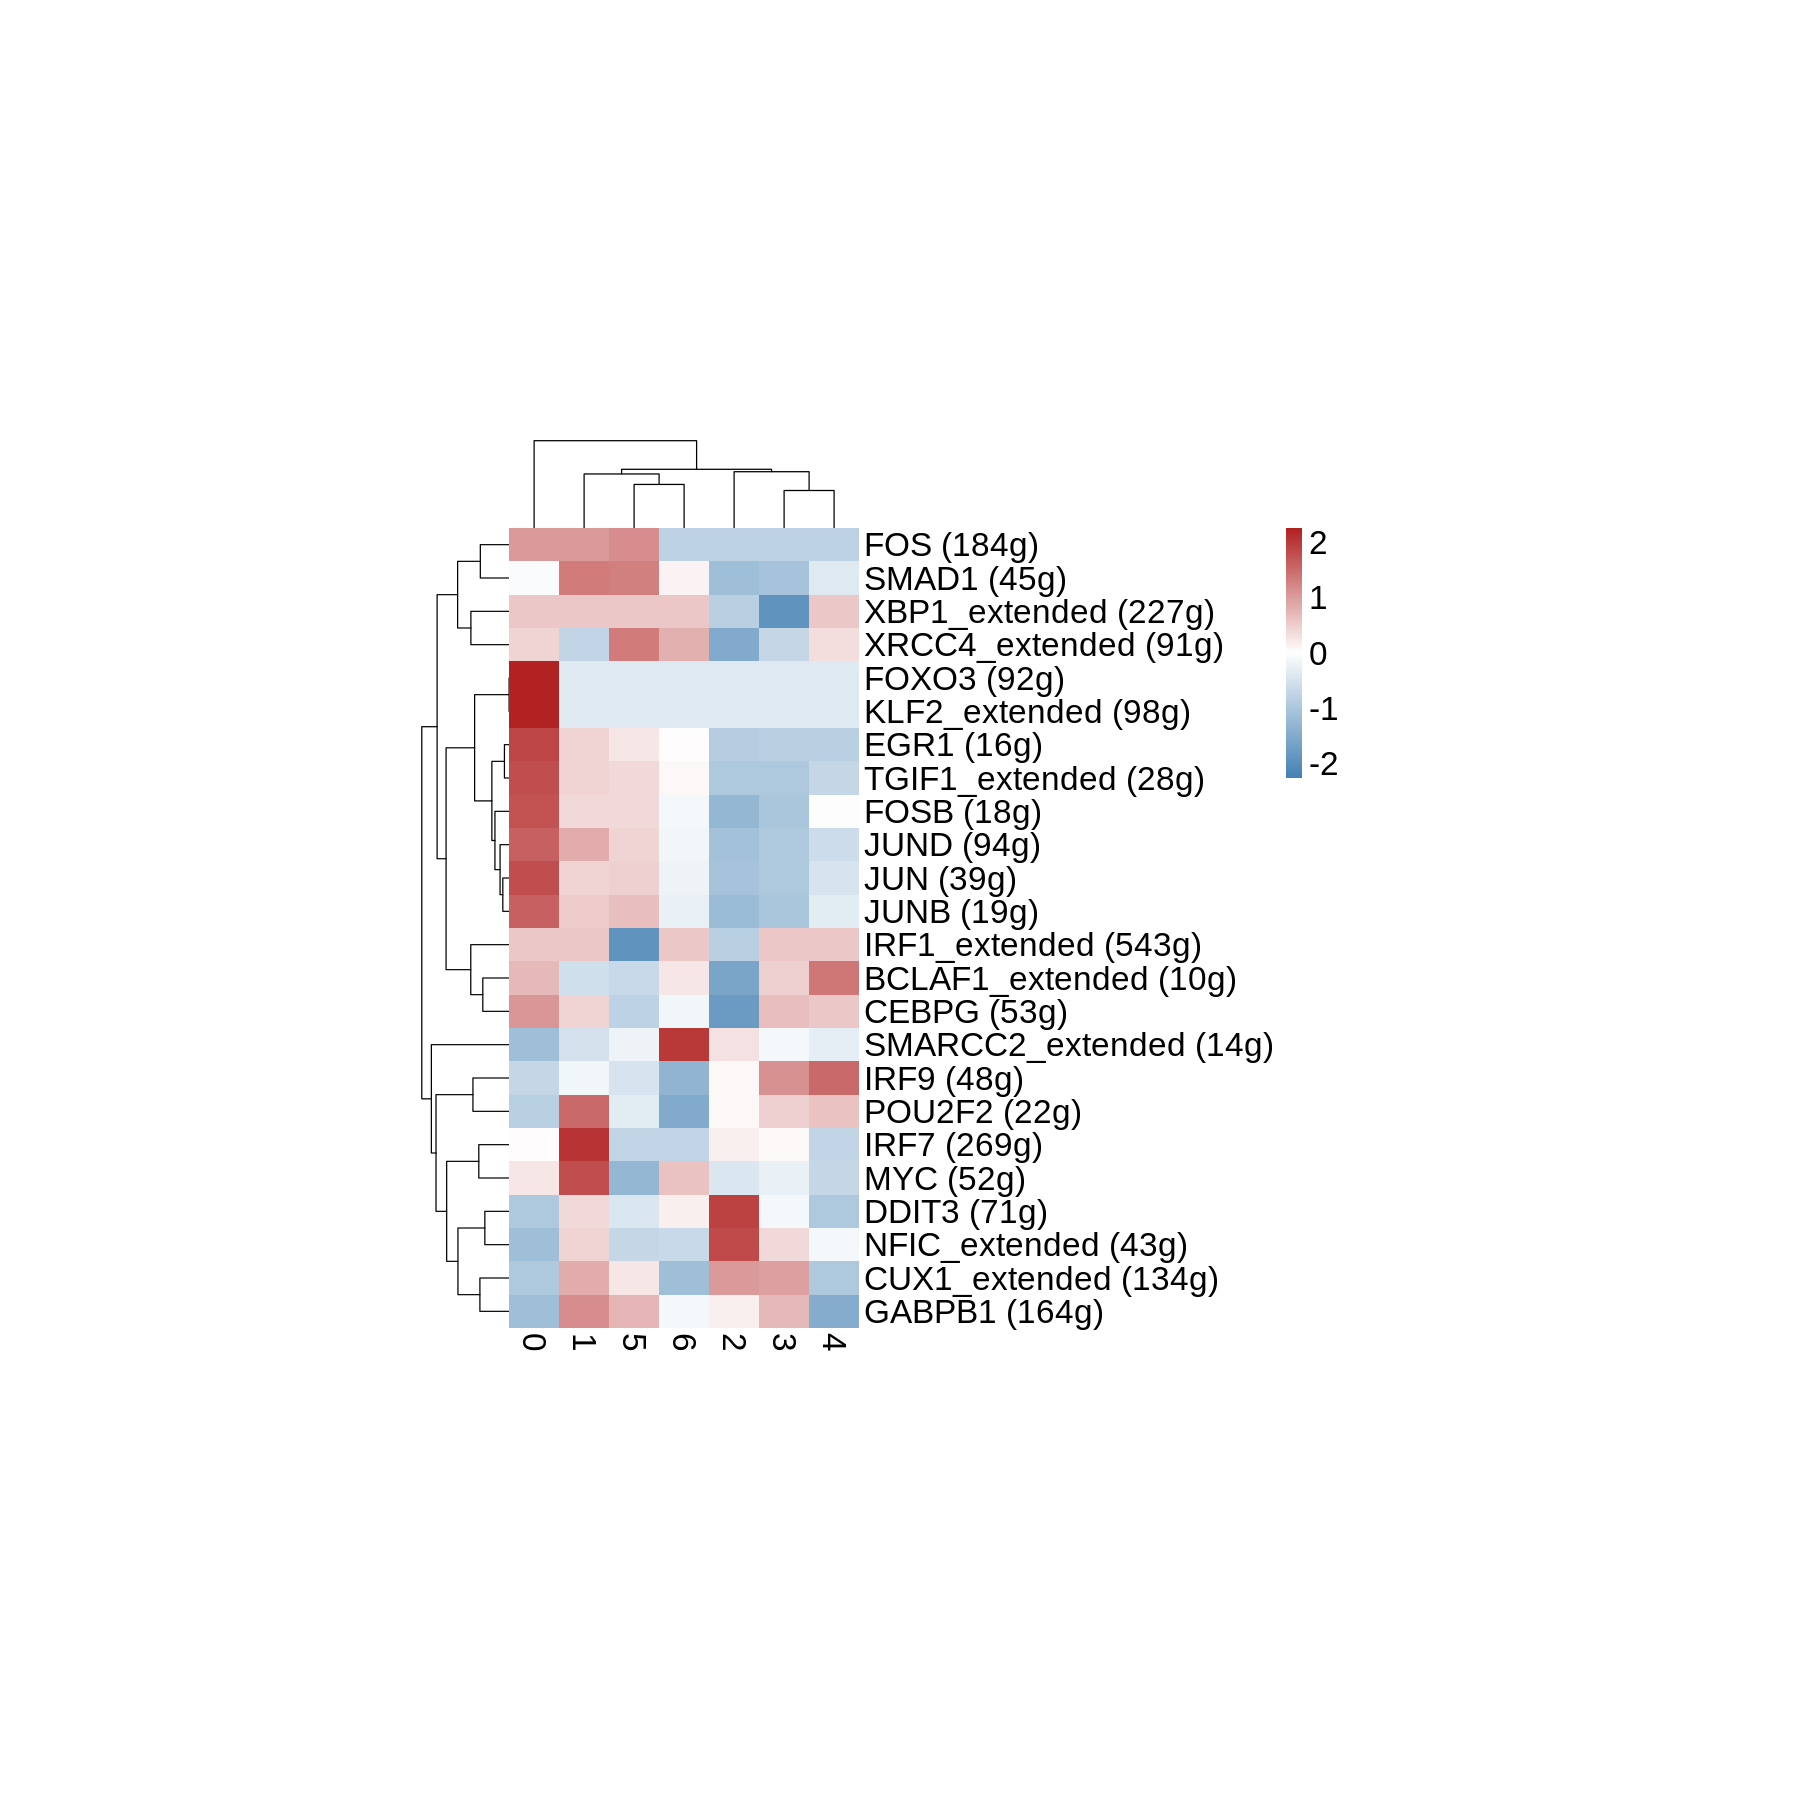

In [48]:
library(pheatmap)
pheatmap(binaryActPerc_subset ,scale="row",border=FALSE,color=colorRampPalette(c('steelblue',"white","firebrick"))(100),cellheight=20,cellwidth=30,fontsize=20)

In [49]:
pheatmap(binaryActPerc_subset ,scale="row",filename='fig2.2.pdf',border=FALSE,color=colorRampPalette(c('steelblue',"white","firebrick"))(100),cellheight=20,cellwidth=30,fontsize=20)

In [50]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Binarized)
colnames(topRegulators) <- c("Regulon", "seuratCluster", "RelativeActivity")
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>minPerc),]
viewTable(topRegulators)

HTML widgets cannot be represented in plain text (need html)

In [51]:
calcRSS <- function(AUC, cellAnnotation, cellTypes=NULL)
{
  if(any(is.na(cellAnnotation))) stop("NAs in annotation")
  if(any(class(AUC)=="aucellResults")) AUC <- getAUC(AUC)
  normAUC <- AUC/rowSums(AUC)
  if(is.null(cellTypes)) cellTypes <- unique(cellAnnotation)
  # 
  ctapply <- lapply
  if(require('BiocParallel')) ctapply <- bplapply
  
  rss <- ctapply(cellTypes, function(thisType)
    sapply(rownames(normAUC), function(thisRegulon)
    {
      pRegulon <- normAUC[thisRegulon,]
      pCellType <- as.numeric(cellAnnotation==thisType)
      pCellType <- pCellType/sum(pCellType)
      .calcRSS.oneRegulon(pRegulon, pCellType)
    })
  )
  rss <- do.call(cbind, rss)
  colnames(rss) <- cellTypes
  return(rss)
}

plotRSS <- function(rss, labelsToDiscard=NULL, zThreshold=1,
                    cluster_columns=FALSE, order_rows=TRUE, trh=0.01, varName="cellType",
                    col.low="grey90", col.mid="darkolivegreen3", col.high="darkgreen",
                    revCol=FALSE)
{
  varSize="RSS"
  varCol="Z"
  if(revCol) {
    varSize="Z"
    varCol="RSS"
  }
  
  rssNorm <- scale(rss) # scale the full matrix...
  rssNorm[rssNorm < zThreshold] <- 0
  rssNorm <- rssNorm[,which(!colnames(rssNorm) %in% labelsToDiscard)] # remove after calculating...
  
  ## to get topic order (easier...)
  tmp <- .plotRSS_heatmap(rssNorm, trh=trh, cluster_columns=cluster_columns, order_rows=order_rows)
  rowOrder <- rev(tmp@row_names_param$labels)
  
  ## Dotplot
  rss.df <- reshape2::melt(rss)
  head(rss.df)
  colnames(rss.df) <- c("Topic", varName, "RSS")
  rssNorm.df <- reshape2::melt(rssNorm)
  colnames(rssNorm.df) <- c("Topic", varName, "Z")
  rss.df <- merge(rss.df, rssNorm.df)
  
  rss.df <- rss.df[which(rss.df$Z >= 1.5),]
  rss.df <- rss.df[which(!rss.df[,varName] %in% labelsToDiscard),] # remove after calculating...
  # dim(rss.df)
  
  rss.df[,"Topic"] <- factor(rss.df[,"Topic"], levels=rowOrder)
  p <- dotHeatmap(rss.df, 
             var.x=varName, var.y="Topic", 
             var.size=varSize, min.size=.5, max.size=5,
             var.col=varCol, col.low=col.low, col.mid=col.mid, col.high=col.high)
  
  invisible(list(plot=p, df=rss.df, rowOrder=rowOrder))
}

#' @aliases plotRSS
#' @export 
plotRSS_oneSet <- function(rss, setName, n=5)
{
  library(ggplot2)
  library(ggrepel)
  
  rssThisType <- sort(rss[,setName], decreasing=TRUE)
  thisRss <- data.frame(regulon=names(rssThisType), rank=seq_along(rssThisType), rss=rssThisType)
  thisRss$regulon[(n+1):nrow(thisRss)] <- NA
  
  ggplot(thisRss, aes(x=rank, y=rss)) + 
    geom_point(color = "blue", size = 1) + 
    ggtitle(setName) + 
    geom_label_repel(aes(label = regulon),
                     box.padding   = 0.35, 
                     point.padding = 0.5,
                     segment.color = 'grey50',
                     na.rm=TRUE) +
    theme_classic()
}



## Internal functions:
.H <- function(pVect){
  pVect <- pVect[pVect>0] # /sum(pVect) ??
  - sum(pVect * log2(pVect))
}

# Jensen-Shannon Divergence (JSD)
calcJSD <- function(pRegulon, pCellType)
{
  (.H((pRegulon+pCellType)/2)) - ((.H(pRegulon)+.H(pCellType))/2)
}

# Regulon specificity score (RSS)
.calcRSS.oneRegulon <- function(pRegulon, pCellType)
{
  jsd <- calcJSD(pRegulon, pCellType)
  1 - sqrt(jsd)
}

.plotRSS_heatmap <- plotRSS_heatmap <- function(rss, trh=NULL, row_names_gp=gpar(fontsize=5), order_rows=TRUE, cluster_rows=FALSE, name="RSS", ...)
{
  if(is.null(trh)) trh <- signif(quantile(rss, p=.97),2)
  
  library(ComplexHeatmap)
  rssSubset <- rss[rowSums(rss > trh)>0,]
  rssSubset <- rssSubset[,colSums(rssSubset > trh)>0]
  message("Showing regulons and cell types with any RSS > ", trh, " (dim: ", nrow(rssSubset), "x", ncol(rssSubset),")")
  
  if(order_rows)
  {
    maxVal <- apply(rssSubset, 1, which.max)
    rss_ordered <- rssSubset[0,]
    for(i in 1:ncol(rssSubset))
    {
      tmp <- rssSubset[which(maxVal==i),,drop=F]
      tmp <- tmp[order(tmp[,i], decreasing=FALSE),,drop=F]
      rss_ordered <- rbind(rss_ordered, tmp)
    }
    rssSubset <- rss_ordered
    cluster_rows=FALSE
  }
  
  Heatmap(rssSubset, name=name, row_names_gp=row_names_gp, cluster_rows=cluster_rows, ...)
} 

In [52]:
cellClusters<-data.frame(rownames(allPC3@meta.data),allPC3@meta.data$seurat_clusters)

In [53]:
rownames(cellClusters)<-cellClusters[,1]
cellClusters[,1]<-NULL

In [54]:
rss <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=cellClusters[colnames(regulonAUC), ])

Loading required package: BiocParallel



In [55]:
rss

,1,0,3,2,4,5,6
MYC (52g),0.20039910,0.45022093,0.09481447,0.13483750,0.08907800,0.05089785,0.032474884
CEBPG (53g),0.19874757,0.43072228,0.10131070,0.12790666,0.08108125,0.04857222,0.029496844
IRF9 (48g),0.18047559,0.29300620,0.11452274,0.14707127,0.10235532,0.04575114,0.022675284
NFIC_extended (43g),0.14175084,0.10760283,0.07632836,0.17299191,0.05402384,0.03140071,0.020634685
DDIT3 (71g),0.17190931,0.20093659,0.07273213,0.17879098,0.04706596,0.04003117,0.029433093
SMARCC2_extended (14g),0.06122501,0.03189943,0.05141138,0.07863290,0.04000401,0.03450511,0.055934184
XRCC4_extended (91g),0.18507896,0.41679151,0.08990855,0.14738774,0.08028419,0.07643678,0.037716053
RREB1_extended (14g),0.07000667,0.04289889,0.05223561,0.09071743,0.03163606,0.06633951,0.009936205
POU2F2 (22g),0.21858798,0.19880275,0.09258279,0.10667750,0.08139917,0.03954111,0.011599371
CTNNB1_extended (11g),0.15874864,0.03317987,0.04826650,0.10027740,0.02331821,0.02299374,0.012275563


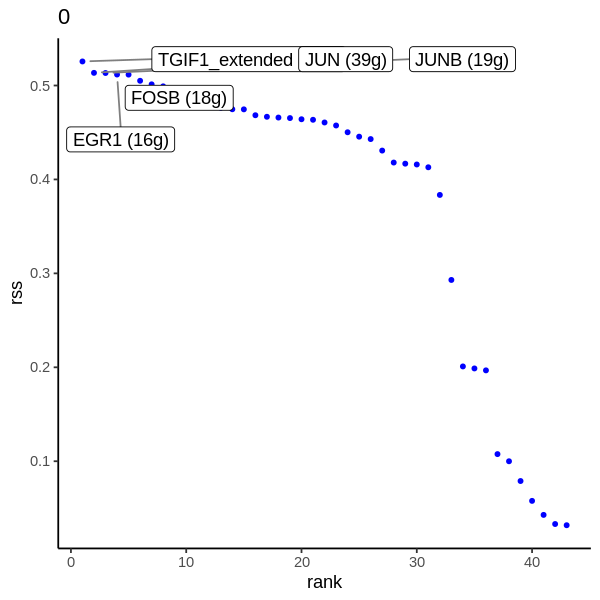

In [56]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "0") # cluster ID

In [58]:
ggsave('fig.s2.3.1.pdf',height=6,width=6)

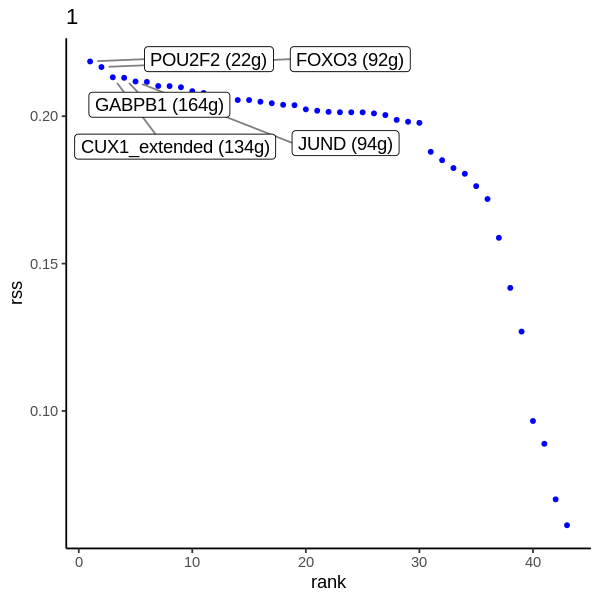

In [59]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "1") # cluster ID

In [60]:
ggsave('fig.s2.3.2.pdf',height=6,width=6)

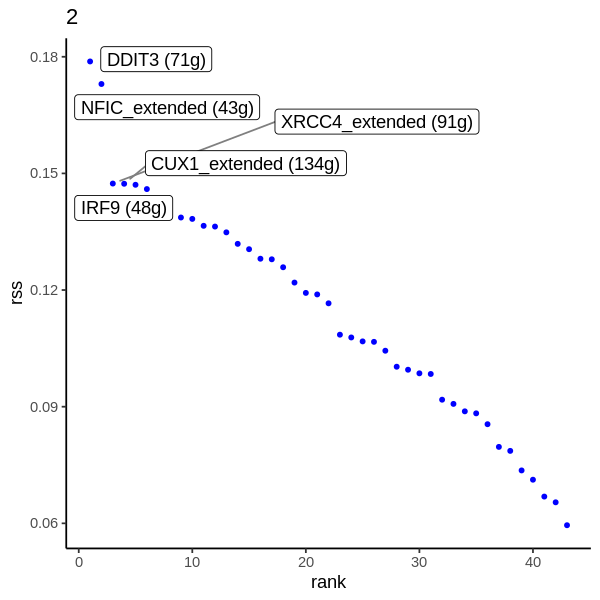

In [61]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "2") # cluster ID

In [62]:
ggsave('fig.s2.3.3.pdf',height=6,width=6)

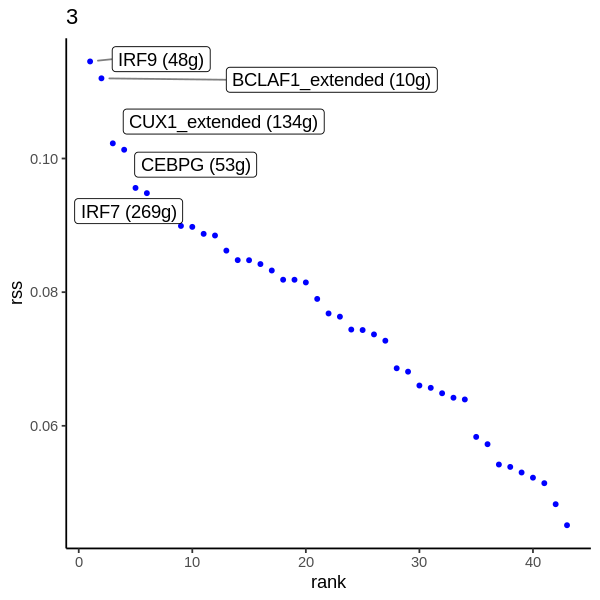

In [63]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "3") # cluster ID

In [64]:
ggsave('fig.s2.3.4.pdf',height=6,width=6)

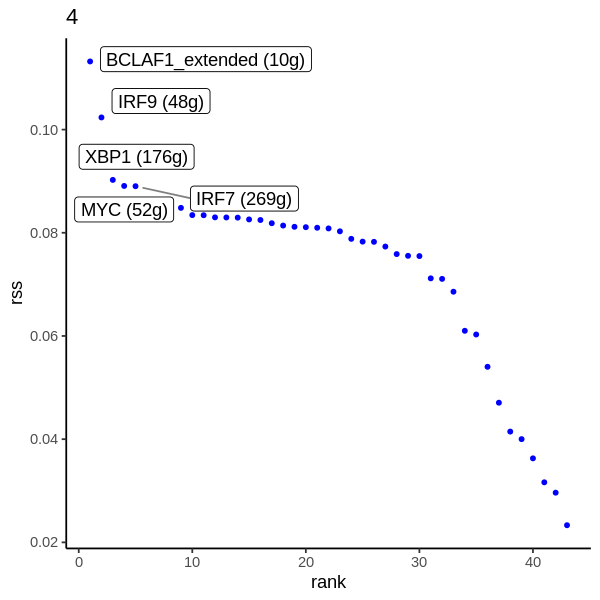

In [65]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "4") # cluster ID

In [66]:
ggsave('fig.s2.3.5.pdf',height=6,width=6)

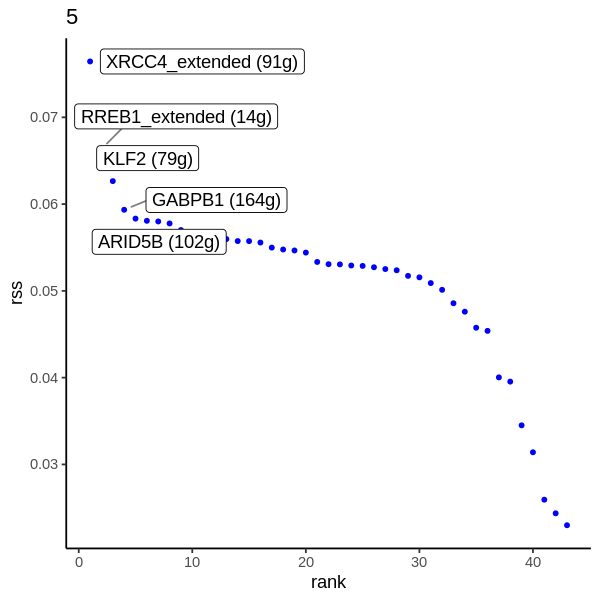

In [67]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "5") # cluster ID

In [68]:
ggsave('fig.s2.3.6.pdf',height=6,width=6)

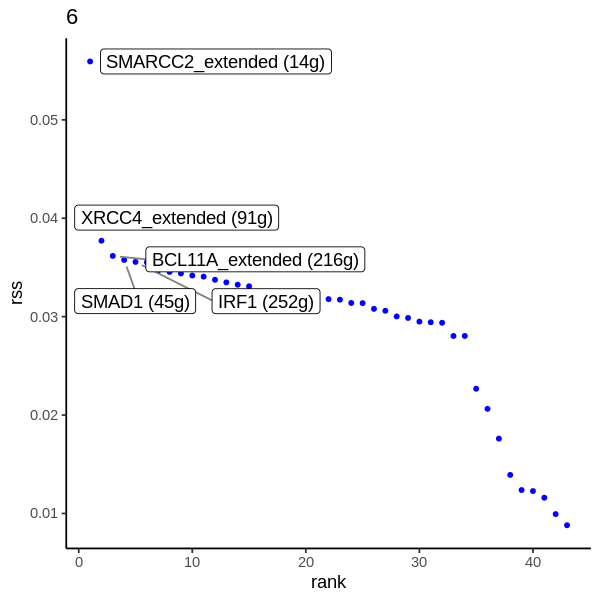

In [69]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "6") # cluster ID

In [70]:
ggsave('fig.s2.3.7.pdf',height=6,width=6)